In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Outputs

/content/drive/MyDrive/Outputs


In [3]:
!pip install azure-storage-blob azure-identity --quiet
!pip install tensorflow-io --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.2/113.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 21.3 MB/s eta 0:00:00


In [4]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

In [5]:
from azure.storage.blob import BlobServiceClient
connection_string = "Add connection string"

# Setup to load file from blob
blob_service_client = "Create Blob Service Client"
container_client = "Create Container Client"

In [6]:
import cloud2cloud_ConvNext as CN
from matplotlib import pyplot as plt
import cv2

####Load Image

In [51]:
frame = 68957

In [52]:
original_image = CN.load_image_from_blob_cv("170418_175706_183328_All_Frames/frame%d.jpg" % frame, container_client)
undistorted_image = CN.undistort_fisheye_image(original_image)
cropped_corrected_image = CN.crop_and_correct_image_cv2(undistorted_image)

Text(0.5, 1.0, 'Original Image')

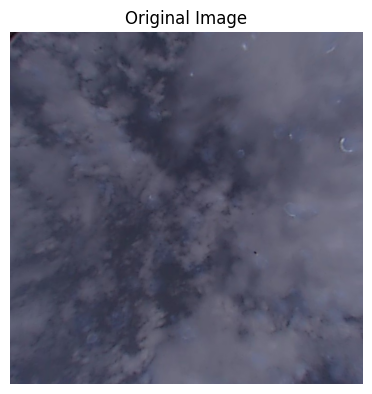

In [53]:
#img2 = cropped_corrected_image[200:700, 200:700]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(cropped_corrected_image, cmap='gray')
plt.title('Original Image')

In [54]:
def get_center_region(img1_1, r_h, r_w):
  h, w = img1_1.shape

  center_x, center_y = w // 2, h // 2
  half_width, half_height =  r_w // 2, r_h // 2
  center_region = (slice(center_y - half_height, center_y + half_height), slice(center_x - half_width, center_x + half_width))

  return center_region

In [55]:
img1 = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
center_region = get_center_region(img1, 600, 600)

#img1 = cropped_corrected_image[200:700, 200:700]
img1 = img1[center_region]

Text(0.5, 1.0, 'Original Image')

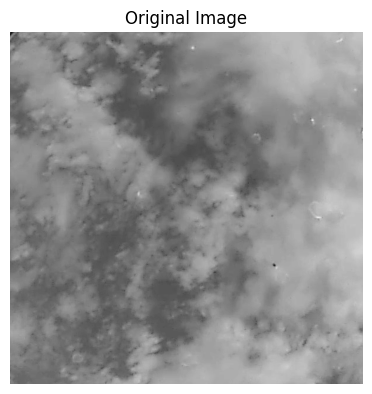

In [56]:

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img1, cmap='gray')
plt.title('Original Image')

####Load Height predictions

In [57]:
ind = 227

In [58]:
heights = pd.read_csv(r"/content/drive/MyDrive/Outputs/Output_%d.csv" % ind)

In [59]:
x = np.outer(np.linspace(0, 600, 600), np.ones(600))
y = x.copy().T # transpose
#z = np.zeros([300,300])
z = np.zeros([600,600])

In [60]:
for ind in heights.index:
    a = int(heights['X'][ind])
    b = int(heights['Y'][ind])

    #if heights['Estimated height'][ind]>5000 and heights['Estimated height'][ind]<14000 and a<300 and b<300:
    if heights['Height'][ind]>0 and heights['Height'][ind]<14000:
        z[a,b] = heights['Height'][ind]

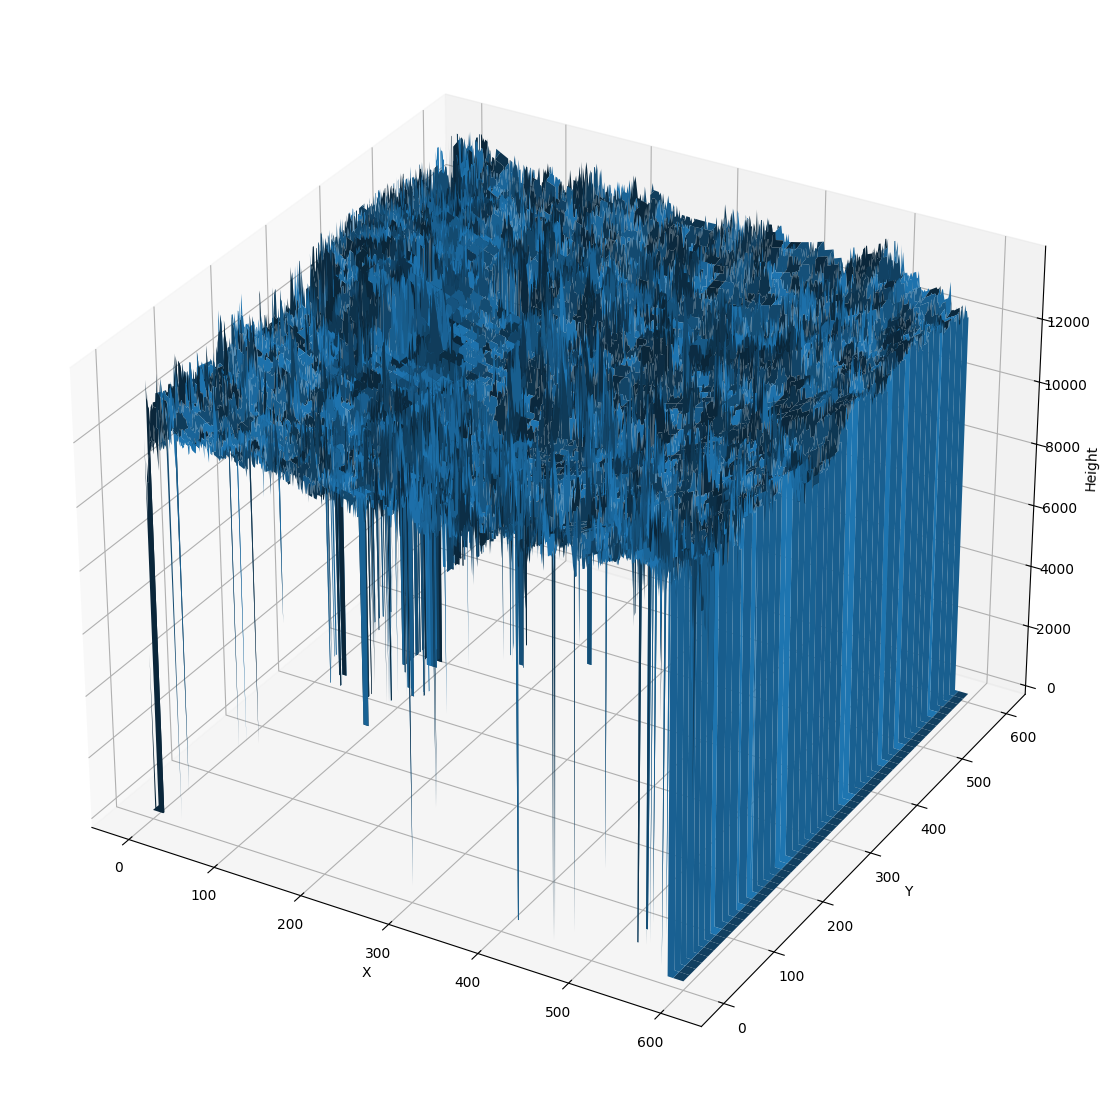

In [61]:
fig = plt.figure(figsize =(14, 20))
ax = plt.axes(projection ='3d')

# Creating plot
ax.plot_surface(x,y,z)

xLabel = ax.set_xlabel('X', linespacing=3.2)
yLabel = ax.set_ylabel('Y', linespacing=3.1)
zLabel = ax.set_zlabel('Height', linespacing=3.4)

# show plot
plt.show()

In [62]:
fig = go.Figure(data=[go.Surface(z=z)])

fig.update_layout(title=dict(text='Heights'), autosize=True,
                    width=500, height=500,
                    margin=dict(l=65, r=50, b=65, t=90))

fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[0,600],),
        yaxis = dict(nticks=4, range=[0,600],),
        zaxis = dict(nticks=4, range=[0,14000],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

fig.show()

#fig.write_html("plot.html")

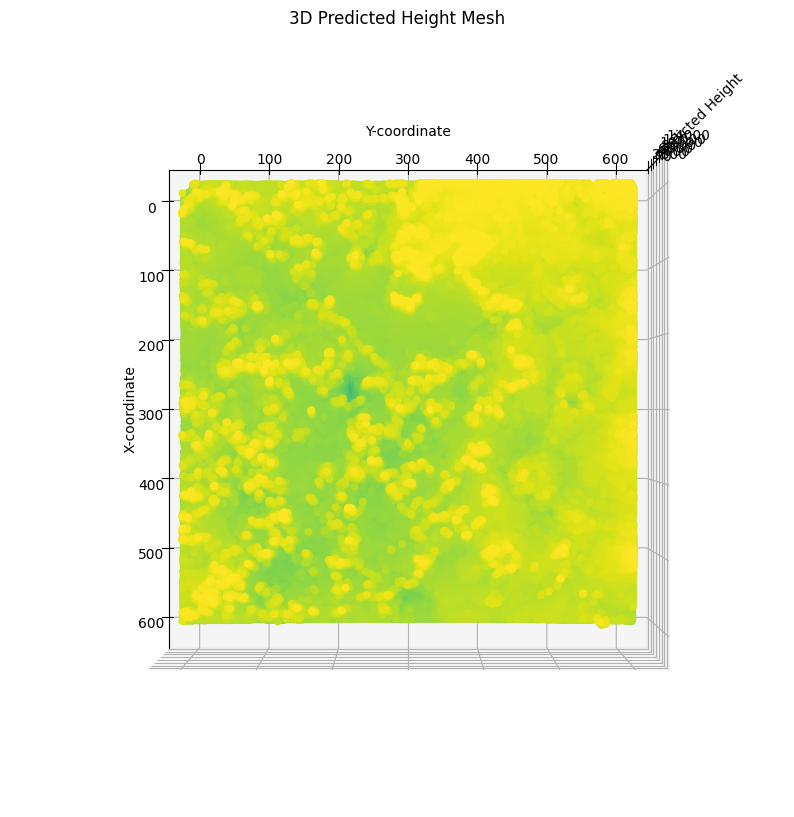

In [63]:
fig = plt.figure(figsize=(10, 20))  # Adjust the figure size if needed
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of pixel locations with height as the z-axis
ax.scatter(x, y, z, c=z, cmap='viridis')  # Use a colormap to represent height

# Set labels and title
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_zlabel('Predicted Height')
ax.set_title('3D Predicted Height Mesh')
ax.view_init(90, 0)

# Show the plot
plt.show()

In [64]:
def get_undistorted_endpoints_1(mu, S, H, W, x, y):
    cx = (W-1)/2        # image center coordinate [pixel]
    cy = (H-1)/2        # image center coordinate [pixel]

    K = np.array([[f/mu,0,cx],[0,f/mu,cy],[0,0,1]])

    # compute intrinsic matrix for ouput image
    cpx = (W*S-1)/2
    cpy = (H*S-1)/2
    P = np.array([[f/mu,0,cpx],[0,f/mu,cpy],[0,0,1]])

    D = np.array([0.01166363, -0.04819808, 0.07918044, -0.037572])

    R = np.eye(3)

    coord_homog = np.array([x, y, 1.0], dtype=np.float32).reshape(-1, 1)
    undistorted_coord = cv2.fisheye.undistortPoints(
        coord_homog.T[:, :2].reshape(1, -1, 2),
        K=K, D=D, R=R, P=P
    )[0][0]
    x_1, y_1 = undistorted_coord

    return x_1, y_1

In [65]:
frame_pixels = 1082
mu = 7.5/1082
f = 1.4
mu_1 = 2.8e-3
S = 2

In [66]:
x_corr = np.zeros([600, 600])
y_corr = np.zeros([600, 600])

for i in range(600):
    for j in range(600):
        k_1, k = get_undistorted_endpoints_1(mu_1, S, 600, 600, j, i)

        x_corr[i,j] = k
        y_corr[i,j] = k_1

In [67]:
Output = np.column_stack((y_corr.ravel(),x_corr.ravel(), heights['Height']))

In [68]:
x = np.outer(np.linspace(0, 1000, 1000), np.ones(1000))
y = x.copy().T # transpose
#z = np.zeros([600,300])
z = np.zeros([1000,1000])

In [69]:
for ind in range(360000):
    a = round(Output[ind][0])-201
    b = round(Output[ind][1])-201

    #if heights['Estimated height'][ind]>5000 and heights['Estimated height'][ind]<14000 and a<300 and b<300:
    if Output[ind][2]>0 and Output[ind][2]<14000:
        z[a,b] = Output[ind][2]

In [70]:
x.shape

(1000, 1000)

In [71]:
np.max(Output[:,:2])

997.7178344726562

In [88]:
z[100][25], z[100][500], z[300][100]

(12732.69, 11622.54, 0.0)